## BERT Classifier using ktrain package

#### Original Notebooks:
https://github.com/amaiya/ktrain  

In [23]:
import warnings
# warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

#### Check for GPU presence

In [2]:
#Verify we got CPU + GPU or only CPU
tf.config.list_physical_devices()

2023-05-23 03:46:59.855769: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-23 03:46:59.874796: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-23 03:46:59.874842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pytorch-1-13-20230518-102004): /proc/driver/nvidia/version does not exist


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
!nvidia-smi

Thu Nov 26 13:51:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    31W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
tf.__version__

'2.3.1'

In [5]:
# !pip install ktrain --upgrade

In [24]:
# import ktrain
import ktrain
from ktrain import text

In [4]:
ktrain.__version__

'0.37.0'

#### Check available text classifiers in ktrain

In [5]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


#### Copy files to local FS from GCP bucket

In [25]:
!mkdir -p /home/jupyter/data/yelp

In [26]:
!gsutil cp -n 'gs://msca-bdp-data-open/yelp/yelp_train_sentiment.json' '/home/jupyter/data/yelp/'

Skipping existing item: file:///home/jupyter/data/yelp/yelp_train_sentiment.json


### Load Data

In [27]:
yelp_path = '/home/jupyter/data/yelp/yelp_train_sentiment.json'

In [28]:
# yelp = pd.read_json(yelp_path, orient='records', lines=True)
yelp = pd.read_json(yelp_path, orient='records', lines=True).head(10000)
yelp.shape

(10000, 3)

In [29]:
yelp.head(5)

,text,label,lang
0,I love Deagan's. I do. I really do. The atmosp...,1,en
1,I love the classes at this gym. Zumba and. Rad...,1,en
2,The tables and floor were dirty. I was the onl...,0,en
3,I had an oil change at the 15515 N Scottsdale ...,0,en
4,The absolute WORST apartment complex I have ev...,0,en


### Prepare source data

In [30]:
sentiment = {0: "Negative", 1: "Positive"}
yelp['sentiment'] = yelp['label'].map(sentiment)

In [31]:
df = yelp[['text', 'sentiment']].rename(columns={'text':'data', 'sentiment':'target'})

In [32]:
df.head(5)

,data,target
0,I love Deagan's. I do. I really do. The atmosp...,Positive
1,I love the classes at this gym. Zumba and. Rad...,Positive
2,The tables and floor were dirty. I was the onl...,Negative
3,I had an oil change at the 15515 N Scottsdale ...,Negative
4,The absolute WORST apartment complex I have ev...,Negative


In [33]:
df.groupby(['target']).count()

,data
target,
Negative,4658
Positive,5342


In [34]:
X_train = df.data.tolist()
Y_train = df.target.tolist()

## STEP 1:  Load and Preprocess the Dataset

Preprocess the data using the texts_from_array function (since the data resides in an array). If your documents are stored in folders or a CSV file you can use the texts_from_folder or texts_from_csv functions, respectively.

In [35]:
maxLen = 200 #each document can be of most <maxLen> words. 0 is used as padding ID.
nGramRange = 1 #size of multi-word phrases to consider
preprocessMode='bert' #Either 'standard' (normal tokenization) or 'bert' tokenization and preprocessing for use with BERT text classification model.
sampleSize = 0.3 #Proportion of training to use for validation

(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=X_train, y_train=Y_train,
                                                                       val_pct=sampleSize,
                                                                       preprocess_mode=preprocessMode, #text must be preprocessed in a specific way for use with BERT
                                                                       maxlen=maxLen)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


## STEP 2:  Load a pretrained BERT model and wrap it in a `ktrain.Learner` object

This step can be condensed into a single line of code, but we execute it as two lines for clarity. (You can ignore the deprecation warnings arising from Keras 2.2.4 with TensorFlow 1.14.0.)  

In [36]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 200


/home/jupyter/.local/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


done.


In [37]:
batchSize = 16 ### Check best size

learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=batchSize)

## STEP 3: Train the Model

We train using one of the three learning rates recommended in the BERT paper: *5e-5*, *3e-5*, or *2e-5*.
Alternatively, the ktrain Learning Rate Finder can be used to find a good learning rate by invoking `learner.lr_find()` and `learner.lr_plot()`, prior to training.
The `learner.fit_onecycle` method employs a [1cycle learning rate policy](https://arxiv.org/pdf/1803.09820.pdf).

In [38]:
# briefly simulate training to find good learning rate

learner.lr_find(max_epochs=3)

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
438/438 [==============================] - 1340s 3s/step - loss: 0.3575 - accuracy: 0.8310
Epoch 2/3
438/438 [==============================] - 1284s 3s/step - loss: 0.7387 - accuracy: 0.6154
Epoch 3/3
438/438 [==============================] - 3s 7us/step - loss: 2.5063 - accuracy: 0.5625


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


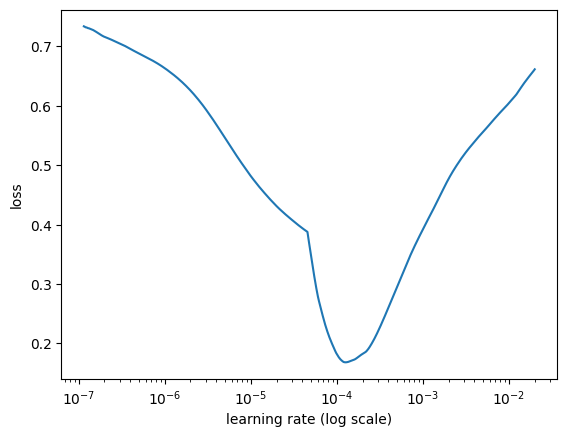

In [39]:
learner.lr_plot()

In [40]:
learningRate = 2e-5
numEpoch = 3

# learner.fit_onecycle(learningRate, numEpoch)
learner.autofit(learningRate, numEpoch)



begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/3
438/438 [==============================] - 1519s 3s/step - loss: 0.1602 - accuracy: 0.9347 - val_loss: 0.0735 - val_accuracy: 0.9750
Epoch 2/3
438/438 [==============================] - 1476s 3s/step - loss: 0.0376 - accuracy: 0.9893 - val_loss: 0.0728 - val_accuracy: 0.9783
Epoch 3/3
438/438 [==============================] - 1472s 3s/step - loss: 0.0189 - accuracy: 0.9947 - val_loss: 0.0733 - val_accuracy: 0.9803


We can use the `learner.validate` method to test our model against the validation set.

In [41]:
learner.validate(val_data=(x_test, y_test))

94/94 [==============================] - 199s 2s/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1397
           1       0.98      0.98      0.98      1603

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



array([[1365,   32],
       [  27, 1576]])

## STEP 4: Making predictions

We can call the `learner.get_predictor` method to obtain a Predictor object capable of making predictions on new raw data.

In [42]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [43]:
predictor.get_classes()

['Negative', 'Positive']

In [44]:
print(predictor.predict(X_train[0:1]))

['Positive']


In [45]:
print(X_train[0:1])

["I love Deagan's. I do. I really do. The atmosphere is cozy and festive. The shrimp tacos and house fries are my standbys. The fries are sometimes good and sometimes great, and the spicy dipping sauce they come with is to die for. The beer list is amazing and the cocktails are great. The prices are mid-level, so it's not a cheap dive you can go to every week, but rather a treat when you do. Try it out. You won't be disappointed!"]


In [46]:
sample_sentiment = pd.read_parquet("gs://cloud-ai-platform-2e11e97a-0212-426c-b0fa-b1f124dd9ef2/sample_for_sentiment.parquet")

In [47]:
sample_sentiment.head(2)

,index,url_x,date_x,title_x,sentiment,url_y,date_y,language,title_y,text,clean_text,manual_label
0,977,https://www.wrdw.com/prnewswire/2022/07/15/vir...,1657843200000,Virtus Artificial Intelligence &amp; Technolog...,positive,https://www.wrdw.com/prnewswire/2022/07/15/vir...,1657843200000,en,Virtus Artificial Intelligence &amp; Technolog...,Virtus Artificial Intelligence &amp; Technolog...,Virtus Artificial Intelligence amp Technology ...,1
1,1373,https://www.com-unik.info/2021/08/12/link-mach...,1628726400000,Link Machine Learning (LML) Trading Up 13.4% O...,positive,https://www.com-unik.info/2021/08/12/link-mach...,1628726400000,en,Link Machine Learning (LML) Trading Up 13.4% O...,\n\nLink Machine Learning (LML) Trading Up 13....,Link Machine Learning LML Trading Up . Over La...,1


In [50]:
sample_sentiment['title_x']

0     Virtus Artificial Intelligence &amp; Technolog...
1     Link Machine Learning (LML) Trading Up 13.4% O...
2     A college student created an app that can tell...
3     Samsung Europe's CMO on AI and the Value of Gu...
4     STAT partners with Applied XL to launch a new ...
                            ...                        
95    Insider Q&A: OpenAI CTO Mira Murati on shepher...
96    UAE AI university, Israel’s Weizmann Institute...
97    Cresta Named "Hot Vendor in AI for the Contact...
98    AONDevices Edge AI Processor Achieves Best-in-...
99    Georgia State Researchers Join $20 Million Pro...
Name: title_x, Length: 100, dtype: object

In [51]:


target = sample_sentiment['manual_label'].tolist()
predicted = predictor.predict(sample_sentiment['title_x'].tolist())
data = sample_sentiment['title_x']

results = pd.DataFrame(list(zip(target, predicted, data)), 
               columns =['target', 'predicted', 'data']) 

In [54]:
pd.set_option('max_colwidth', 100)

results.head(10)

,target,predicted,data
0,1,Positive,Virtus Artificial Intelligence &amp; Technology Opportunities Fund Discloses Sources of Distribu...
1,1,Positive,Link Machine Learning (LML) Trading Up 13.4% Over Last 7 Days - Community Financial News
2,1,Positive,A college student created an app that can tell whether AI wrote an essay | Wyoming Public Media
3,1,Positive,Samsung Europe's CMO on AI and the Value of Gut Knowledge
4,1,Positive,STAT partners with Applied XL to launch a new clinical trials monitoring platform powered by art...
5,1,Positive,This 22-year-old is trying to save us from ChatGPT before it changes writing forever | Prairie P...
6,1,Positive,Trade Ideas | December 2021 AI Dashboard: Monthly Sector Transactions and Rotations | Nasdaq
7,1,Positive,Artificial Intelligence in Platform as a Service Market Extensive Demand in Upcoming Years and F...
8,1,Positive,Schools turn to artificial intelligence for efficient campus administration | BusinessWorld
9,1,Positive,Avalanche Computing Launches Revolutionary Low-Code AI Tool at CES 2022


In [57]:
results['comparison'] = ((results['target'] == 1) & (results['predicted'] == 'Positive')) | ((results['target'] == 0) & (results['predicted'] == 'Negative'))


In [58]:
results.comparison.sum()*100/results.comparison.count()

83.0